In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


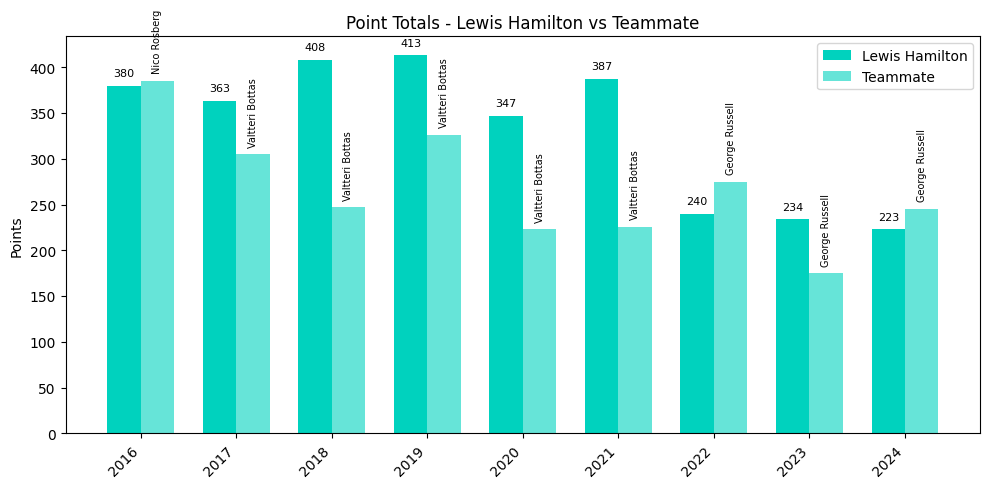

In [ ]:
# --- Team color map ---
team_colors = {
    'Red Bull':            '#1E41FF',
    'Mercedes':            '#00D2BE',
    'Ferrari':             '#DC0000',
    'McLaren':             '#FF8700',
    'Aston Martin':        '#006F62',
    'Alpine':              '#0090FF',
    'Williams':            '#005AFF',
    'AlphaTauri':          '#2B4562',
    'AlphaTauri F1 Team':  '#2B4562',
    'Haas F1 Team':        '#B6BABD',
    'Alfa Romeo':          '#900000'
}

def lighten_color(hex_color: str, amount: float = 0.4) -> str:
    
    rgb = mcolors.to_rgb(hex_color)
    light_rgb = [c + (1 - c) * amount for c in rgb]
    return mcolors.to_hex(light_rgb)
def get_base_color(team_name: str) -> str:
    
    for key, col in team_colors.items():
        if key.lower() in team_name.lower():
            return col
    return '#888888'  
def compare_driver_vs_teammate(
    df: pd.DataFrame,
    driver_name: str,
    team_pattern: str,
    year_min: int = None,
    lighten_amount: float = 0.4
):
   
    mask = df['Team'].str.contains(team_pattern, case=False, regex=True)
    if year_min is not None:
        mask &= df['Year'].ge(year_min)
    df_filt = df.loc[mask].copy()

    drv_seasons = (
        df_filt[df_filt['Driver'] == driver_name]
          .groupby('Year')
          .agg({'P':'sum','RS':'sum'})
          .rename(columns={'P':'Drv_P','RS':'Drv_RS'})
    )
    drv_team = df_filt[df_filt['Driver'] == driver_name][['Year','Team','RS']]
    idx_tm = drv_team.groupby('Year')['RS'].idxmax()
    main_team = drv_team.loc[idx_tm, ['Year','Team']]
    others = (
        df_filt
        .merge(main_team, on=['Year','Team'], how='inner')
        .query("Driver != @driver_name")
    )
    idx_tm2 = others.groupby('Year')['RS'].idxmax()
    primary_tm = (
        others.loc[idx_tm2, ['Year','Driver','P']]
              .set_index('Year')
              .rename(columns={'Driver':'Teammate','P':'TM_P'})
    )
    comp = drv_seasons[['Drv_P']].join(primary_tm)
    comp = comp.join(main_team.set_index('Year'))
    comp.sort_index(inplace=True)
    driver_colors   = []
    teammate_colors = []
    for team in comp['Team']:
        base = get_base_color(team)
        driver_colors.append(base)
        teammate_colors.append(lighten_color(base, amount=lighten_amount))

    years = comp.index.astype(str)
    x     = np.arange(len(years))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,5))
    bars_drv = ax.bar(x - width/2, comp['Drv_P'],     width,
                      label=driver_name, color=driver_colors)
    bars_tm  = ax.bar(x + width/2, comp['TM_P'],      width,
                      label='Teammate',    color=teammate_colors)
    y_off = comp['Drv_P'].max() * 0.02
    for rect in bars_drv:
        h = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, h + y_off,
                f"{int(h)}", ha='center', va='bottom', fontsize=8)
    for rect, tm in zip(bars_tm, comp['Teammate']):
        if pd.notna(tm):
            h = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, h + y_off,
                    tm, ha='center', va='bottom',
                    rotation=90, fontsize=7)

    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=45, ha='right')
    ax.set_ylabel('Points')
    ax.set_title(f"Point Totals - {driver_name} vs Teammate")
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df = pd.read_csv(RedBullCurse\MercedesHistorical.csv')
    compare_driver_vs_teammate(
        df,
        driver_name='Lewis Hamilton',
        team_pattern=r'mercedes',
        year_min=2016,
        lighten_amount=0.4
    )